Laboratorio 1 - Regresión lineal 
Integrantes: 
Silvana Echeverry - 202310470
David Mora - 
Carlos Vargas

In [1]:
#importando librerias 

import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
data_train = pd.read_csv('data/datos_entrenamiento_laboratorio1(train_data).csv')
data_test = pd.read_csv('data/datos_validacion_laboratorio1(test_data).csv')

**Entendimiento de los datos**

Para esta primera etapa, decidimos hacer uso de diferentes funciones para entender como se comportaban nuestros datos, como: 
* Head() -> muestra las primera filas del data frame con las columnas 
* isna().sum() -> nos permitio contar los datos que tenian valores nulos,
* dtypes -> saber los tipos de las variables que tenemos

Despues de hacer esta exploración de los datos, nos dimos cuenta que ciertas variables importantes estaban con valores nulos, o variables importantes estaban con valores que no les correspondian, por ejemplo: 
- edad: object -> y deberia ser int
- market value: object -> y deberia ser int
- dia de partido: object -> fecha 
y con los valores nulos: 
- Edad 48
- Nacionalidad 32
- %_de_regates_exitosos 28.722
- %_de_duelos_aereos_ganados 20.957
- market_value 12.894 (solo esta en el archivo de entrenamiento)
- contract_date 12.916

nota: el pais también deberia cambiarse para dejarlo solamente con su codigo ejm: ARG -> Argentina

Nuestra variable objetivo es predecir el valor de mercado de un jugador (market_value) a partir de sus estadísticas registradas durante partidos. 

Cada fila del data set representa el desempeño de un jugador en un partido especifico (fecha de partido). Nos podemos dar cuenta que hay multiples registros de cada jugador en cada uno de los partidos. 

Además, encontramos que ciertas columnas estan repetidas con datos duplicados como: 
- xAG
- Pasos_Progresivos
- Regates_Exitosos
- Pases_completados

Para hacer una correcta estimación, en esta etapa consideramos que hacen falta variables en cuenta para la estimación, como: 
- partidos_jugados: Cantidad total de partidos registrados por jugador en la temporada
- valor_por_partido: Valor de mercado dividido entre partidos_jugados, ya que segun el partido pueden tener diferente valor
- posicion_general: una variable que categorice la posición del jugador
- años_fincontrato: calcular los años hasta que se le acabe el contrato

Variables mas significativas para nuestro modelo (hasta el momento), consideramos que en esta primera revisión estos son los datos mas relevantes para nuestro modelo 
1. Edad
2. posicion_general (nueva variable)
3. partidos_jugados (nueva variable)
4. Goles
5. xG
6. xA
7. xAG
8. Acciones_que_crean_tiros
9. Pases_al_hueco
10. Pases_en_ultimo_tercio
11. Regates_exitosos
12. Toques_en_area_rival
15. Faltas_cometidas
16. Valla_no_vencida 
17. valor_por_partido (nueva variable)
18. años_fincontrato (nueva variable)
19. Pases_progresivos
20. Pases_intentados
21. Nacionalidad 

In [45]:
' Usamos estas lineas de codigo para explorar los datos '
#data_test.head()
#data_train.head()
#data_train.isna().sum() #verificando datos nulos
#data_test.isna().sum()
#data_test.dtypes
#data_train.dtypes

' Usamos estas lineas de codigo para explorar los datos '

**2. Preparación de los datos**


comenzamos filtrando con la fecha de contrato, lo que hacemos es conseguir la ultima fecha de contrato que tiene registrada el jugador. 
rellenamos los nulls con el promedio que tienen los otros jugadores de fecha de contrato

In [67]:
#convertir la fecha de contrato a datetime
data_train['contract_date'] = pd.to_datetime(data_train['contract_date'], errors='coerce')

#calculo el promedio de los contratos de los jugadores para rellenar los nulos, lo hice para revisar cuanto en promedio dura un contrato de un jugador y añadirle esa fecha 
contract_date_mean = data_train['contract_date'].dropna().mean()

data_train['contract_date'] = data_train['contract_date'].fillna(contract_date_mean)

# aca saco la fecha maxima de contrato por jugador para quedarme con la ultima fecha de contrato de cada jugador 
idxl = data_train.groupby('Jugador')['contract_date'].idxmax()

# ahora con esto filtro el data frame para quedarme con la ultima fecha de contrato de cada jugador
data_train = data_train.loc[idxl]


C:\Users\david\AppData\Local\Temp\ipykernel_34936\727014576.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_train['contract_date'] = pd.to_datetime(data_train['contract_date'], errors='coerce')


ahora filtramos con el dia de partido para conseguir el ultimo dia de partido disponible

In [47]:
#dia de partido en el formato datetime
data_train['Dia_partido'] = pd.to_datetime(data_train['Dia_partido'], errors='coerce')

# 1. Eliminar registros donde 'Dia_partido' es NaN
data_train_valid_fecha = data_train.dropna(subset=['Dia_partido'])

# 2. Obtener el índice del último partido por jugador
idx_fecha = data_train_valid_fecha.groupby('Jugador')['Dia_partido'].idxmax()

# 3. Filtrar solo esos registros
data_train = data_train_valid_fecha.loc[idx_fecha]


hacemos las conversiones de edad, ya que en el data set original tienen valores compuestos entonces tenemos que transformar a int para poder transformarlos

In [48]:
# convertir Edad a string para trabajar con texto para que la division sea mas facil
data_train["Edad"] = data_train["Edad"].astype(str)

# eliminar lo que está después del guion, que no nos sirve
data_train["Edad"] = data_train["Edad"].str.split('-').str[0]

# reemplazar 'nan' (como texto) por np.nan
data_train["Edad"] = data_train["Edad"].replace("nan", np.nan)

# convertir a número
data_train["Edad"] = pd.to_numeric(data_train["Edad"], errors='coerce')


data_train["Edad"] = data_train["Edad"].fillna(0)

# obtener el índice de la fila con la edad máxima por jugador
idxe = data_train.groupby('Jugador')["Edad"].idxmax()

# filtrar el DataFrame para dejar solo esa fila por jugador
data_train = data_train.loc[idxe]

hacemos lo mismo para nacionalidad, y nos quedamos con los ultimos digitos del codigo ejm Argentina -> ARG

In [49]:
# convertir a string por si hay valores no string
data_train["Nacionalidad"] = data_train["Nacionalidad"].astype(str)

# extraer las últimas 3 letras (el código del país) para que sea mas facul manejarlas
data_train["Nacionalidad"] = data_train["Nacionalidad"].str[-3:]

data_train["Nacionalidad"] = data_train["Nacionalidad"].fillna("UNK")  #llenar los nulos con UNK 

comenzamos eliminando los -, error y €, ya que estan estorbando porque no los podemos manipular. 
usamos el market value ultimo digito para hacer una multiplicación de 1millon y 100mil
reemplazamos los k y los m 
y eliminamos los que no tienen valor porque consideramos que no son significativos para estimarlos

In [50]:
data_train['market_value_f'] = data_train['market_value'].str.replace('-', '0')
data_train['market_value_f'] = data_train['market_value_f'].str.replace('error', '0')
data_train['market_value_f'] = data_train['market_value_f'].str.replace('€', '')
data_train['market_value_ultimodigito'] = data_train['market_value_f'].str[-1] #ultimo digito
data_train['market_value_ultimodigito'] = data_train['market_value_ultimodigito'].map({'m': 10000000, 'k': 1000})
data_train['market_value_f'] = data_train['market_value_f'].str.replace('k', '').str.replace('m', '').astype(float)
data_train['market_value_f'] = data_train['market_value_f'] * data_train['market_value_ultimodigito']

#llenar los nulls con la mediana
market_value_median = data_train['market_value_f'].median()
data_train['market_value_f'] = data_train['market_value_f'].fillna(market_value_median)

data_train = data_train.drop(columns=['market_value', 'market_value_ultimodigito'])
#data_train[data_train['market_value_f'].isna()] #verficaa con 1 y 0 si esta nula, filtra las filas de ese valor en null 

Para crear la nueva variable, posición general del jugador, dividomos en listas las posiciones que estaban en data set en lo que correspondrian en una evaulación general. esto nos permitira en un futuro evaluar al jugador.

In [51]:

porteros = {"GK"}

defensas = {"CB", "LB", "RB", "WB", "RWB", "LWB"}  # centrales, laterales y carrileros

centrocampistas = {
    "DM", "CM", "AM",  # mediocentro defensivo, centrocampista, mediapunta
    "LM", "RM",        # volantes/extremos de medio campo
    # variantes comunes opcionales:
    "LDM","RDM","LCM","RCM","LAM","RAM"
}

delanteros = {"FW", "ST", "CF", "LW", "RW"}  # delantero, punta, segundo punta, extremos

# Función de mapeo (maneja posiciones múltiples tipo "DM,CM")
def map_posicion_general(pos):
    if pd.isna(pos):
        return np.nan
    etiquetas = [p.strip().upper() for p in str(pos).split(",") if p.strip()]

    # Prioridad si hay múltiples etiquetas: Portero > Defensa > Centrocampista > Delantero
    if any(p in porteros for p in etiquetas):
        return "Portero"
    if any(p in defensas for p in etiquetas):
        return "Defensa"
    if any(p in centrocampistas for p in etiquetas):
        return "Centrocampista"
    if any(p in delanteros for p in etiquetas):
        return "Delantero"


#crear la nueva variable 
data_train["posicion_general"] = data_train["Posicion"].apply(map_posicion_general)



eliminar las columnas que encontramos que estaban repetidas

In [52]:

mask_keep = ~data_train.T.duplicated(keep='first')   # True=conservar, False=duplicada
keep_idx = np.where(mask_keep)[0]
drop_idx = np.where(~mask_keep)[0]

cols_to_drop = data_train.columns[drop_idx].tolist()

print("Columnas a ELIMINAR por ser duplicadas de alguna anterior (índice, nombre):")
for i in drop_idx:
    print(f"{i:>3d}  {data_train.columns[i]}")
print("\nTotal eliminadas:", len(drop_idx))
print("Total resultantes:", len(keep_idx))

# eliminar por posición (índice)
data_train = data_train.iloc[:, keep_idx].copy()

# Chequeo rápido
print("\nPrimeras columnas tras limpieza:")
print(data_train.columns[:20].tolist())

data_train


Columnas a ELIMINAR por ser duplicadas de alguna anterior (índice, nombre):
 10  xAG.1
 13  Pases_intentados.1
 14  Pases_intentados.2
 16  Pases_progresivos.1
 18  Regates_exitosos.1
 21  xAG.2
 22  xAG.3
 30  Pases_completados.1
 31  Pases_completados.2
 45  Centros

Total eliminadas: 10
Total resultantes: 41

Primeras columnas tras limpieza:
['Jugador', 'Nacionalidad', 'Posicion', 'Edad', 'Dia_partido', 'Goles', 'Tiros Totales', 'xG', 'npxG', 'xAG', 'Acciones_que_crean_tiros', 'Pases_intentados', 'Pases_progresivos', 'Regates_exitosos', 'Pases_medios_completados', 'Pases_largos_completados', 'xA', 'Pases_en_ultimo_tercio', 'Pases_balon_vivo', 'Pases_balon_muerto']


,Jugador,Nacionalidad,Posicion,Edad,Dia_partido,Goles,Tiros Totales,xG,npxG,xAG,...,Malos_controles,Perdida_balon,Pases_recibidos,Pases_progresivos_recibidos,Faltas_cometidas,Duelos_aereos_ganados,%_de_duelos_aereos_ganados,contract_date,market_value_f,posicion_general
25245,Aaron Ciammaglichella,ITA,CM,19.0,2024-08-25,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,NaN,2026-06-30 00:00:00.000000000,700000.0,Centrocampista
509,Aaron Cresswell,ENG,LB,34.0,2024-08-24,0,0,0.0,0.0,0.0,...,0,0,1,0,0,1,100.0,2028-04-05 09:41:01.780937216,80000000.0,Defensa
42880,Aaron Malouda,FRA,FW,19.0,2025-01-25,0,0,0.0,0.0,0.0,...,0,1,1,0,0,0,NaN,2028-04-05 09:41:01.780937216,80000000.0,Delantero
24784,Aaron Martin,ESP,"WB,LM",27.0,2024-08-17,0,0,0.0,0.0,0.0,...,1,0,17,3,1,0,0.0,2026-06-30 00:00:00.000000000,65000000.0,Defensa
772,Aaron Ramsdale,ENG,GK,26.0,2024-08-31,0,0,0.0,0.0,0.0,...,0,0,28,0,0,0,NaN,2028-06-30 00:00:00.000000000,100000000.0,Portero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12259,Ørjan Nyland,NOR,GK,33.0,2024-08-16,0,0,0.0,0.0,0.0,...,0,0,33,0,0,0,NaN,2026-06-30 00:00:00.000000000,900000.0,Portero
29097,Þorir Johann Helgason,ISL,"LW,LM",24.0,2024-11-25,0,1,0.0,0.0,0.0,...,1,0,3,2,1,0,NaN,2026-06-30 00:00:00.000000000,30000000.0,Centrocampista
38664,Đorđe Petrovic,SRB,GK,24.0,2024-09-15,0,0,0.0,0.0,0.0,...,0,0,43,0,0,0,NaN,2028-04-05 09:41:01.780937216,80000000.0,Portero
850,Łukasz Fabianski,POL,GK,39.0,2024-08-31,0,0,0.0,0.0,0.0,...,0,0,2,0,0,0,NaN,2028-04-05 09:41:01.780937216,80000000.0,Portero


Exploración de variables

en esta parte vamos a revisar el modelo y que tanto nos funcionan las varibles antes de hacer el modelo de regresión lineal

In [53]:
data_train.info()

data_train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 2231 entries, 25245 to 24928
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Jugador                         2231 non-null   object        
 1   Nacionalidad                    2231 non-null   object        
 2   Posicion                        2231 non-null   object        
 3   Edad                            2231 non-null   float64       
 4   Dia_partido                     2231 non-null   datetime64[ns]
 5   Goles                           2231 non-null   int64         
 6   Tiros Totales                   2231 non-null   int64         
 7   xG                              2231 non-null   float64       
 8   npxG                            2231 non-null   float64       
 9   xAG                             2231 non-null   float64       
 10  Acciones_que_crean_tiros        2231 non-null   int64         
 11  Pase

,Jugador,Nacionalidad,Posicion,Edad,Dia_partido,Goles,Tiros Totales,xG,npxG,xAG,...,Malos_controles,Perdida_balon,Pases_recibidos,Pases_progresivos_recibidos,Faltas_cometidas,Duelos_aereos_ganados,%_de_duelos_aereos_ganados,contract_date,market_value_f,posicion_general
count,2231,2231,2231,2231.000000,2231,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,...,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,1277.000000,2231,2.231000e+03,2231
unique,2231,110,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,Aaron Ciammaglichella,ESP,CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defensa
freq,1,398,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777
mean,NaN,NaN,NaN,25.057373,2024-09-25 03:33:38.646347008,0.460332,0.600179,0.061407,0.056387,0.040879,...,0.699238,0.450022,19.584043,1.749440,0.655312,0.674585,47.934534,2028-04-01 02:34:53.353101568,1.772820e+08,NaN
min,NaN,NaN,NaN,0.000000,2024-08-15 00:00:00,-5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2026-06-30 00:00:00,5.000000e+04,NaN
25%,NaN,NaN,NaN,22.000000,2024-08-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,2027-06-30 00:00:00,5.000000e+07,NaN
50%,NaN,NaN,NaN,25.000000,2024-08-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,15.000000,1.000000,0.000000,0.000000,50.000000,2028-04-05 09:41:01.780937216,8.000000e+07,NaN
75%,NaN,NaN,NaN,28.000000,2024-09-22 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,28.000000,2.000000,1.000000,1.000000,100.000000,2028-06-30 00:00:00,1.400000e+08,NaN
max,NaN,NaN,NaN,41.000000,2025-05-25 00:00:00,689.000000,7.000000,1.800000,1.200000,1.500000,...,10.000000,6.000000,123.000000,22.000000,8.000000,9.000000,100.000000,2035-06-30 00:00:00,9.999990e+10,NaN


Aca queremos ver como se distribuye nuestra variable objetivo 

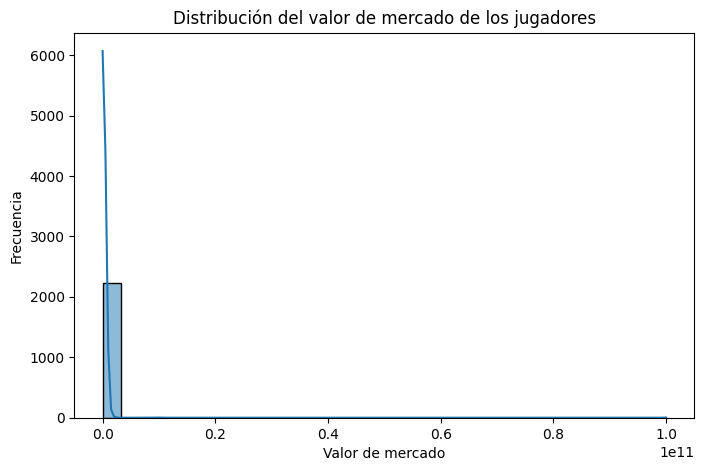

In [54]:
plt.figure(figsize=(8, 5))
sns.histplot(data_train['market_value_f'], bins=30, kde=True)
plt.title("Distribución del valor de mercado de los jugadores")
plt.xlabel("Valor de mercado")
plt.ylabel("Frecuencia")
plt.show()

Creamos la matriz de correlaciones 

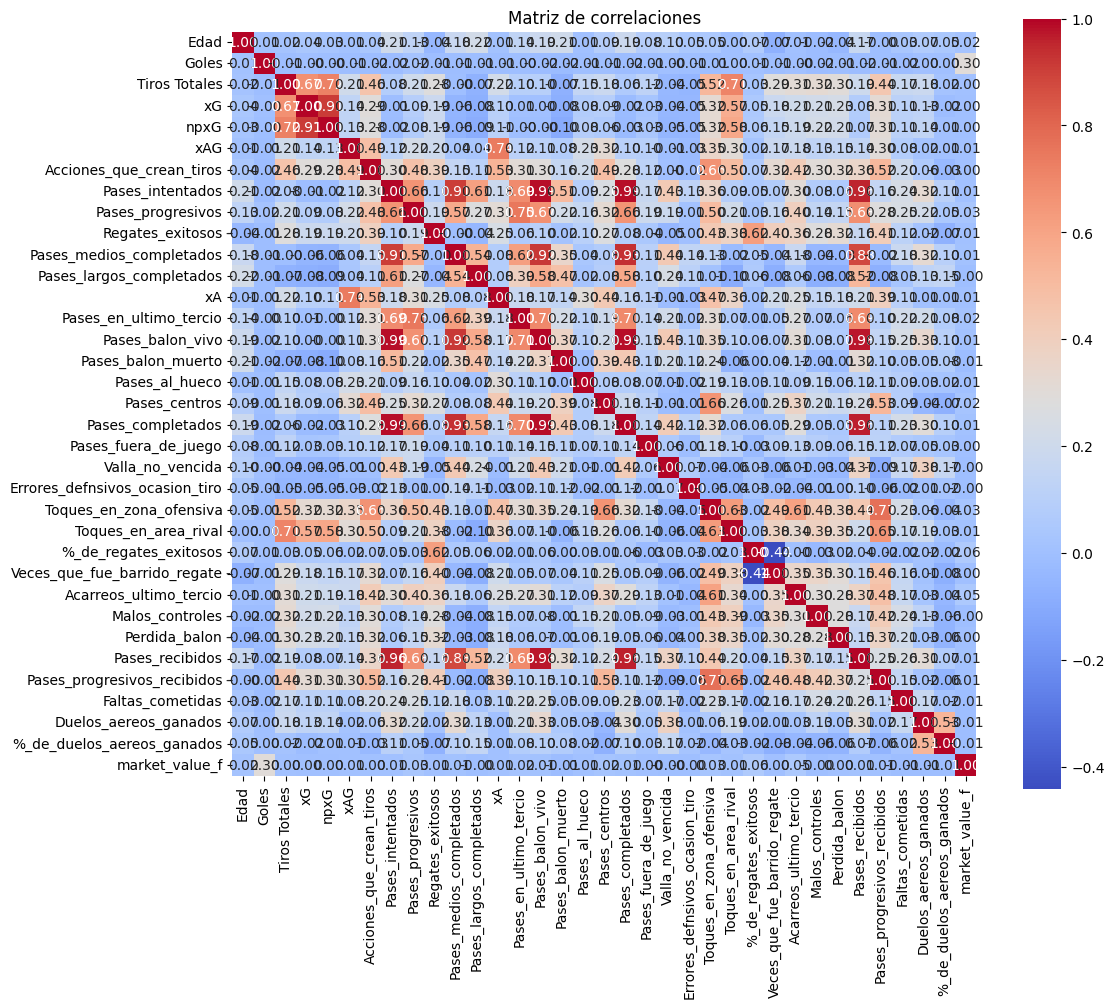

In [55]:
# Selecciona solo columnas numéricas, porque solo numericas 
numericas = data_train.select_dtypes(include='number')

# Calcular matriz de correlación
correlation_matrix = numericas.corr()

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de correlaciones")
plt.show()

decidimos realizar diferentes graficas para observar el comportamiento de nuestras variables y poder tomar conclusiones adecuadas

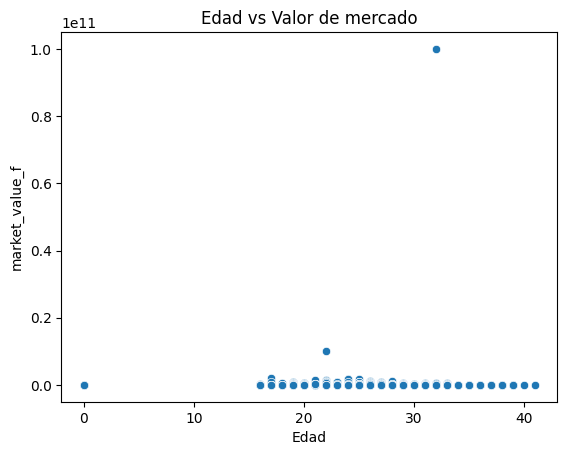

In [56]:
# Relación Edad vs Valor de mercado
sns.scatterplot(x='Edad', y='market_value_f', data=data_train)
plt.title("Edad vs Valor de mercado")
plt.show()


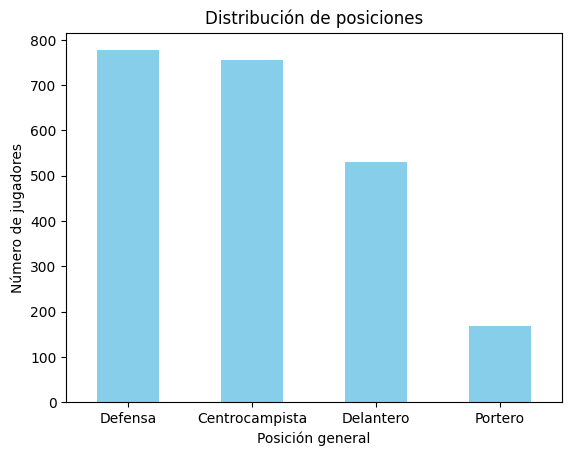

In [57]:
data_train['posicion_general'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribución de posiciones")
plt.ylabel("Número de jugadores")
plt.xlabel("Posición general")
plt.xticks(rotation=0)
plt.show()

Después de observar los resultados de la matriz de correlaciones, llegamos a estas conclusiones: 

1. Valores que estan muy correlacionados entre si y que dependen mucho de otros para su calculo deben ser eliminados de nuestra estimación. Como por ejemplo % de regates exitosos con veces que fue barrido en regate, pases en ultimo tercio con Xa, toques en area rival con toques en zona ofensiva 
2. También encontramos varias que no tienen correlación con nuestro modelo, como pases fuera de juego, faltas cometidas, valla no vencida y pases balon muerto
3. Nos dimos cuenta que las variables explicativas mas importantes, son edad, goles, tiros_totales, npxG, Xa, pases pregresivos, toques en area rival, % de regates exitosos, pases progresivos y posición general. 

para revisar mas a fondo cuales son las variables correlacionadas decidimos crear una función que nos permita ver mas facil las variables que estan correlacionadas mayores a 0,65, 

In [58]:
def variables_correlacionadas(dataframe, umbral=0.65):
    numeric_df = dataframe.select_dtypes(include=[np.number])
    
    corr_matrix = numeric_df.corr().abs()

    # Crear una lista para guardar los pares de columnas altamente correlacionadas
    correlaciones_altas = []

    # Recorrer la matriz para extraer pares con correlación mayor al umbral
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            valor = corr_matrix.iloc[i, j]
            if valor > umbral:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                correlaciones_altas.append((col1, col2, round(valor, 2)))

    # convertir en DataFrame ordenado por la correlación
    correlaciones_df = pd.DataFrame(correlaciones_altas, columns=['Variable 1', 'Variable 2', 'Correlación'])
    correlaciones_df = correlaciones_df.sort_values(by='Correlación', ascending=False)

    return correlaciones_df

correlaciones = variables_correlacionadas(data_train, umbral=0.65)

print(correlaciones)

                  Variable 1                   Variable 2  Correlación
9           Pases_intentados             Pases_balon_vivo         0.99
10          Pases_intentados            Pases_completados         0.99
22          Pases_balon_vivo            Pases_completados         0.99
23          Pases_balon_vivo              Pases_recibidos         0.98
11          Pases_intentados              Pases_recibidos         0.96
25         Pases_completados              Pases_recibidos         0.96
17  Pases_medios_completados            Pases_completados         0.93
16  Pases_medios_completados             Pases_balon_vivo         0.92
7           Pases_intentados     Pases_medios_completados         0.91
3                         xG                         npxG         0.91
18  Pases_medios_completados              Pases_recibidos         0.88
26   Toques_en_zona_ofensiva  Pases_progresivos_recibidos         0.77
12         Pases_progresivos       Pases_en_ultimo_tercio         0.75
4     

La anterior función nos permitió ver exactamente cual era el nivel de correlación entre las variables. De lo anterior decidimos concluir que las variables mas significativas serian: 
1. Pases completados 
2. xG
3. Pases_progresivos 
4. Tiros totales 
5. Acciones_que_crean_tiros 

In [59]:
columnas_a_eliminar = [
    
    'Pases_balon_vivo',
    'Pases_intentados',
    'Pases_recibidos',
    'Pases_medios_completados',
    'Pases_centros',
    'npxG',
    'xA',
    'xAG',
    'Pases_en_ultimo_tercio',
    'Pases_progresivos_recibidos',
    'Toques_en_area_rival',
    'Toques_en_zona_ofensiva'
]

data_train = data_train.drop(columns=columnas_a_eliminar, errors='ignore')



Volvemos a verificar la matriz de correlaciones

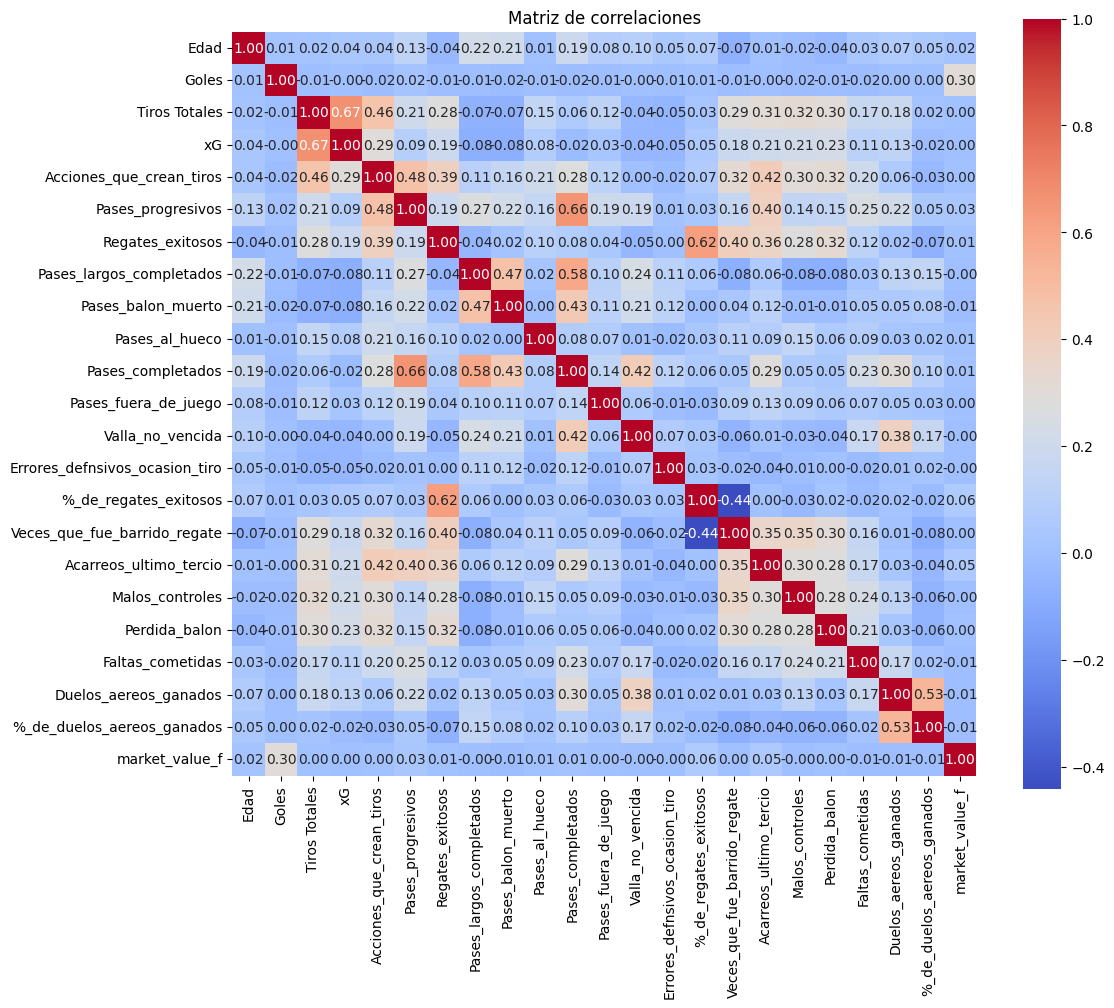

In [60]:
# Selecciona solo columnas numéricas, porque solo numericas 
numericas = data_train.select_dtypes(include='number')

# Calcular matriz de correlación
correlation_matrix = numericas.corr()

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de correlaciones")
plt.show()

Con la matriz de correlaciones más resumida podemos ver que ciertas variables no estan correlacionadas con nuestra variable objetivo entonces no tendria sentido tenerlas en cuenta

In [61]:
columnas_a_eliminar = [
    
    'Tiros Totales', 
    'xG', 
    'Acciones_que_crean_tiros',
    'Pases_largos_completados',
    'Pases_fuera_de_juego', 
    'Valla_no_vencida', 
    'Errores_defensivos_ocasion_tiro', #no se esta eliminando esta variable bien  
    'Veces_que_fue_barrido_regate', 
    'Malos_controles', 
    'Perdida_balon'
    ]

data_train = data_train.drop(columns=columnas_a_eliminar, errors='ignore')


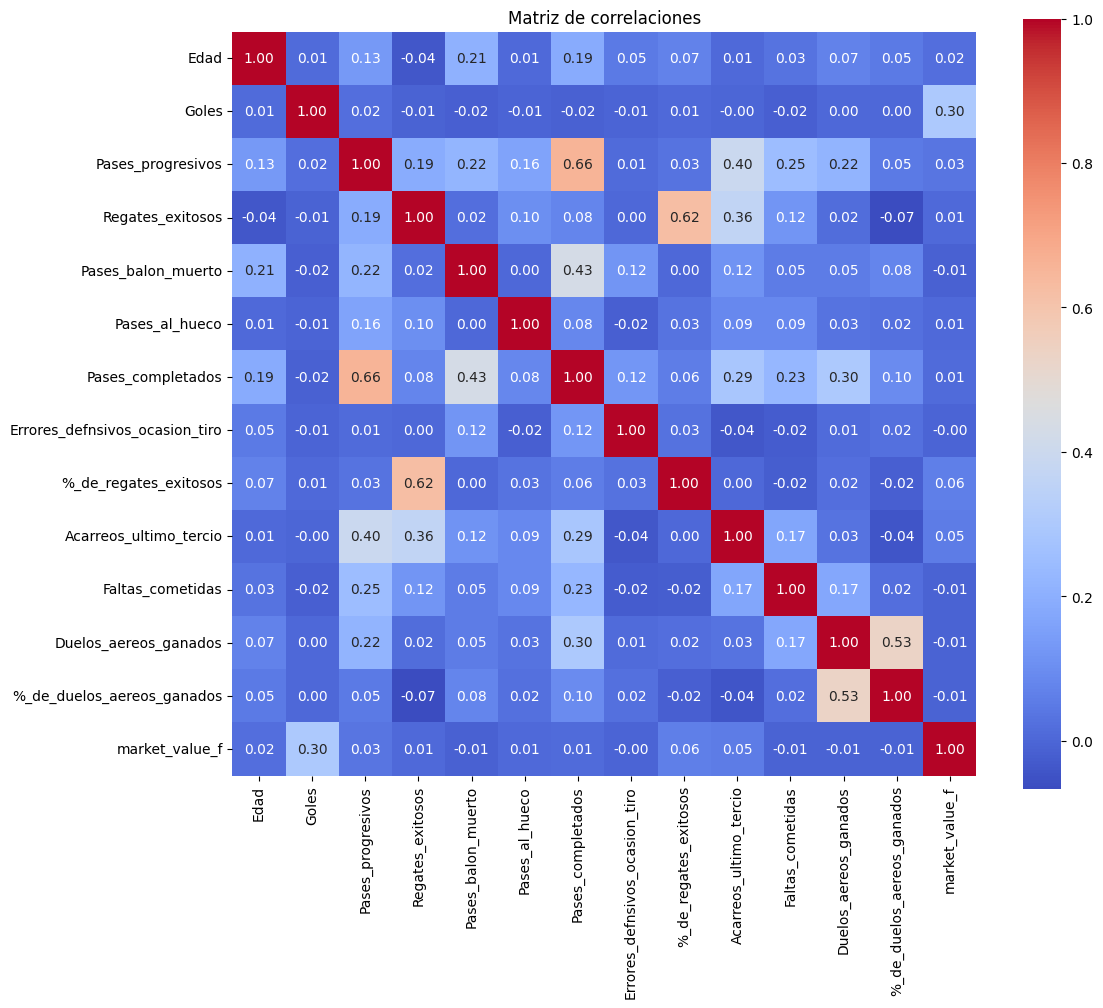

In [62]:
# Selecciona solo columnas numéricas, porque solo numericas 
numericas = data_train.select_dtypes(include='number')

# Calcular matriz de correlación
correlation_matrix = numericas.corr()

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de correlaciones")
plt.show()

In [63]:
# 1. Eliminar columnas no numéricas que no aportan al modelo
columnas_no_usar = ['Jugador', 'Posicion']  # Puedes ajustar esto si alguna la necesitas
X = data_train.drop(columns=['market_value_f'] + columnas_no_usar)

# 2. Convertir variables categóricas en variables dummy (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# 3. Definir y
y = data_train['market_value_f']

# 4. Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 6. Predicciones
y_pred = modelo.predict(X_val)

# 7. Métricas
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>)